# Evaluation
- EGNN generated ~60% higher binding affinity, but SE3 Transformer only ~0.04%. But SE3T obtained better CNN scores
   - This could be because the stretch of egnn generated mols are small, i.e., the atoms stay closely around the center.
   - SE3 Transformer generated normal stretch but we haven't manage to generate candidates with better binding affinity so far.
   - Actually SE3T might generate atoms too distant, so that during reconstruction they are not regarded as connected

In [5]:
import pandas as pd 
import numpy as np
import os
from math import ceil
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
import re

In [6]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [7]:
import sys
sys.path.append('../evaluation/')

In [8]:
from utils import build_pdb_dict

## MSE loss

In [5]:
bridge_type = 'vp'

# egnn
# fixed point init
root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_45.077216'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104'
# Gaussian noise init
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_04_23.779433'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_06_28.209248'

# transformer
# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-06-01_21_36_34.208973'
# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-05-31_23_42_37.443630'

# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-06-18_14_36_42.924053'
# root_path = '../lightning _logs/vp_bridge_CombinedSparseGraphDataset_2024-06-18_14_37_44.491071'

aromatic = False
# log_path = '../../docking_res/logs/' + bridge_type

In [33]:
bridge_type = 've'

# egnn
# root_path = '../lightning_logs/ve_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_42.795058'
root_path = '../lightning_logs/ve_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_52.002393'

aromatic = False

## CE/NLL loss

In [57]:
bridge_type = 'vp'

# egnn
# fixed point init
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_44_27.850031'
root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_43_48.858042'

aromatic = False

In [58]:
log_path = os.path.join(root_path, 'logs')
log_path = log_path+'_aromatic' if aromatic else log_path
gen_path = os.path.join(root_path, 'reconstructed_mols')
gen_path = gen_path+'_aromatic_mode' if aromatic else gen_path

raw_data_path = '../../data/cleaned_crossdocked_data/raw'

log_files = os.listdir(log_path)
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [59]:
len(log_files)

15263

In [60]:
def get_minimized_affinity(filename, mode='ref'):
    if mode == 'ref':
        with open(filename, 'r') as file:
            for line in file:
                if '<minimizedAffinity>' in line:
                    # The next line after '<minimizedAffinity>' contains the value
                    return float(next(file))
            
    else:
        with open(filename, 'r') as f:
            lines = f.readlines()
            lines = lines[19:28]
#             print(len(lines))
            n = len(lines)
            arr = np.zeros(n)
#             print(filename)
            for i in range(n):
                arr[i] = float(lines[i][11:17])
#             print(arr)
            try:
                score = np.min(arr)
            except:
                score = None
                print(f'{filename} failed')
                print('its scores: ', arr)
        return score

In [61]:
def get_affinity_best_pose(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        lines = lines[19:28]
        try:
            score = float(lines[0][11:17])
            cnn_score = float(lines[0][24:30])
        except:
            score = None
            cnn_score = None
        return score, cnn_score

In [62]:
score_dict = {}
for log_file in tqdm(log_files):
    ligand_name = log_file.split('.')[0]
    ligand_file = ligand_name + '.sdf'
    pdb_folder = pdb_rev_dict[ligand_file]
    ref_file = os.path.join(raw_data_path, pdb_folder, ligand_file)
    ref_score = get_minimized_affinity(ref_file, 'ref')
#     print(log_file)
    # gen_score = get_minimized_affinity(os.path.join(log_path, log_file), 'gen')
    gen_score, cnn_score = get_affinity_best_pose(os.path.join(log_path, log_file))
    score_dict[ligand_name] = [gen_score, cnn_score, ref_score]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15263/15263 [00:48<00:00, 315.23it/s]


In [63]:
df = pd.DataFrame.from_dict(score_dict, orient='index', columns=['Binding affinity', 'CNN score', 'Reference'])
df

,Binding affinity,CNN score,Reference
5v7a_B_rec_5u0w_9mg_lig_tt_min_0,-4.59,3.13,-6.30578
1mpw_A_rec_1mpw_tmh_lig_tt_min_0,-4.71,0.88,-4.59814
4buv_A_rec_4ui6_ecz_lig_tt_docked_2,-0.39,19.01,-7.17269
3u6i_A_rec_3efk_mt4_lig_tt_docked_0,-9.93,36.51,-12.66759
4yjf_A_rec_1ve9_bez_lig_tt_min_0,-4.63,1.02,-5.21280
...,...,...,...
5i2n_A_rec_5tp9_7h0_lig_tt_docked_1,-6.30,20.57,-6.25611
1n8k_A_rec_1ldy_cxf_lig_tt_min_0,-3.81,-0.06,-1.73841
2o2u_A_rec_2o2u_738_lig_tt_min_0,-5.40,0.74,-9.12490
4bny_B_rec_4bo4_36g_lig_tt_min_0,-7.08,33.28,-10.65342


In [64]:
filtered_df = df.loc[df['Binding affinity']<df['Reference']]
filtered_df

,Binding affinity,CNN score,Reference
1mpw_A_rec_1mpw_tmh_lig_tt_min_0,-4.71,0.88,-4.59814
3lxp_A_rec_4gih_0x5_lig_tt_min_0,-7.43,47.53,-5.84482
4bud_A_rec_4hl5_15w_lig_tt_docked_7,-8.42,13.61,-7.92064
4wrh_A_rec_4hmn_16j_lig_tt_docked_10,-8.78,4.13,-7.27339
2nnq_A_rec_4nns_75d_lig_tt_docked_0,-8.86,12.99,-7.60088
...,...,...,...
4l33_A_rec_3mhj_m3f_lig_tt_min_0,-8.62,13.63,-6.31680
3kxh_A_rec_2pvj_p44_lig_tt_min_0,-8.96,34.04,-8.28785
5is6_A_rec_5lv2_dxe_lig_tt_docked_0,-3.33,1.02,-3.03914
5i2n_A_rec_5tp9_7h0_lig_tt_docked_1,-6.30,20.57,-6.25611


In [65]:
sorted_df = filtered_df.sort_values(by='CNN score', ascending=False)
sorted_df

,Binding affinity,CNN score,Reference
3vt6_A_rec_3vt5_yi2_lig_tt_docked_0,-12.32,99.37,-12.06582
2zmm_A_rec_1q6m_p27_lig_tt_min_0,-10.75,99.08,-10.31510
3bzu_B_rec_4hx5_19v_lig_tt_docked_0,-11.92,98.96,7.47205
3vjt_A_rec_3vru_ys3_lig_tt_docked_1,-12.46,98.56,-12.14529
3cwe_A_rec_1q6j_335_lig_tt_min_0,-7.67,98.51,-7.55907
...,...,...,...
3ch6_A_rec_3byz_h11_lig_tt_min_0,-7.94,-0.48,-7.38026
1l4e_A_rec_1jhu_pcr_lig_tt_min_0,-3.24,-0.52,-2.70516
1d0s_A_rec_1d0s_dmd_lig_it1_it2_tt_docked_5,-4.19,-0.57,0.90676
1l4g_A_rec_1jhy_iph_lig_tt_min_0,-3.27,-0.60,-2.81887


In [66]:
ba_res_filename = os.path.join(root_path, 'binding_affinity')
ba_res_filename = ba_res_filename+'_aromatic.csv' if aromatic else ba_res_filename+'.csv'

sorted_df.to_csv(ba_res_filename)

In [67]:
sum(df['Binding affinity'] < df['Reference']) / len(df)

0.12730131691017493

In [71]:
def test_ref_ligand(ligand, path=gen_path, raw_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    example = os.path.join(path, ligand+'.sdf')
    m = Chem.MolFromMolFile(example)
    # m = Chem.AddHs(m)

    pdb_folder = pdb_rev_dict[ligand+'.sdf']
    ref_file = os.path.join(raw_path, pdb_folder, ligand+'.sdf')
    ref_m = Chem.MolFromMolFile(ref_file)
    return m, ref_m

In [72]:
lig = '3vt6_A_rec_3vt5_yi2_lig_tt_docked_0'

In [73]:
pdb_rev_dict[lig+'.sdf']

'VDR_RAT_116_422_ligBind_0'

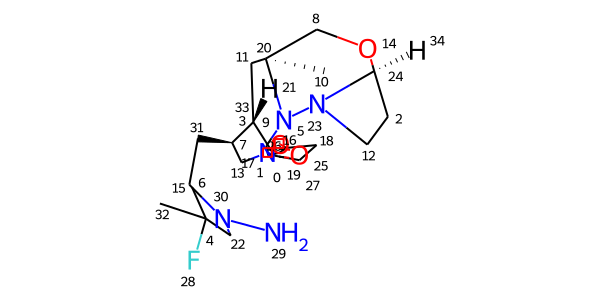

In [74]:
m, ref_m = test_ref_ligand(lig) 
m

[21:54:52] Molecule does not have explicit Hs. Consider calling AddHs()


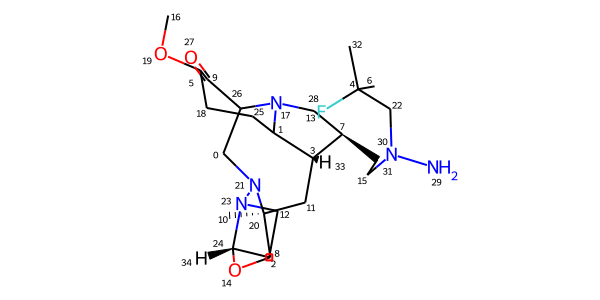

In [75]:
# m = Chem.AddHs(m, addCoord=True)
UFFOptimizeMolecule(m)
m

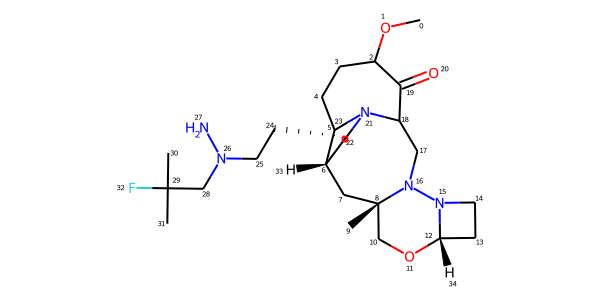

In [76]:
m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(m))
m_2d

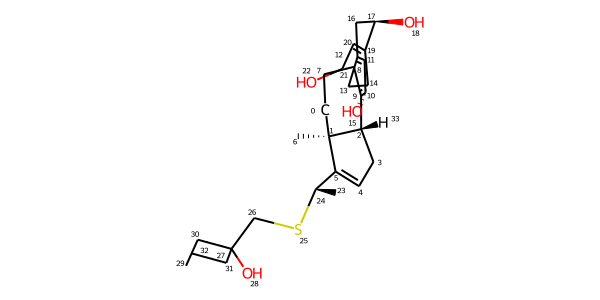

In [77]:
ref_m

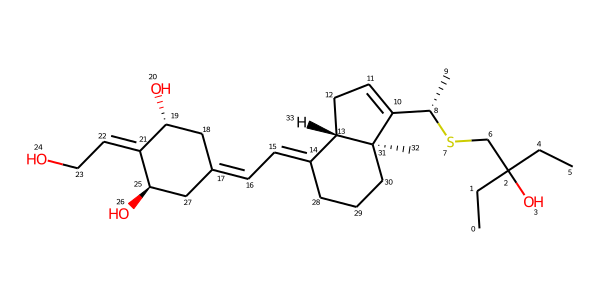

In [78]:
ref_m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(ref_m))
ref_m_2d

In [79]:
def viz(ligand, path=gen_path):
    example = os.path.join(path, ligand+'.sdf')
    
    v = py3Dmol.view()
    v.addModel(open(example).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    
    return v

In [80]:
viz(lig)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [81]:
def viz_with_pr(ligand, root_path=root_path, raw_data_path=raw_data_path, pdb_rev_dict=pdb_rev_dict, aromatic=True):
    # example = os.path.join(path, ligand+'.sdf')

    pattern = r"(\w+_[A-Z]_rec)"
    match = re.search(pattern, ligand)
    pdb_folder = pdb_rev_dict[ligand + '.sdf']
    pr_pdb = match.group(1)
    print(pr_pdb)
    protein_file = os.path.join(raw_data_path, pdb_folder, pr_pdb + '.pdb')

    ligand_fn = ligand[ligand.rfind('rec')+4:ligand.rfind('lig')+3]

    autobox_ligand_file = os.path.join(raw_data_path, pdb_folder, ligand_fn + '.pdb')

    out_folder = 'output_aromatic' if aromatic else 'output'
    out_file = os.path.join(root_path, out_folder, ligand + '.sdf')
    # out_file = os.path.join('../../', ligand + '.sdf')
    
    v = py3Dmol.view()
    v.addModel(open(protein_file).read())
    v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(autobox_ligand_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModelsAsFrames(open(out_file).read())
    v.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    v.zoomTo({'model':1})
    v.rotate(90)
    v.animate({'interval':1000})
    
    return v

In [32]:
viz_with_pr(lig, aromatic=aromatic)

5pb7_A_rec


3Dmol.js failed to load for some reason. Please check your browser console for error messages.